<font size=6><b> 데이콘 Basic 칼로리 소모량 예측 AI 경진대회

* ref : https://dacon.io/competitions/official/236097/overview/description

<pre>
ID : 샘플 별 고유 id
Exercise_Duration  : 운동 시간(분)
Body_Temperature(F) : 체온
BPM : 심박수
Height(Feet) : 키(피트)
Height(Remainder_Inches) : 키(피트 계산 후 더해야 할 키)
Weight(lb) : 몸무게(파운드)
Weight_Status : 체중 상태
Gender : 성별
Age : 나이
Calories_Burned : 칼로리 소모량(목표 예측값)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

sns.set() 
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
# plt.rcParams['font.family']= 'Malgun Gothic'  # 한글 처리
# plt.rcParams['axes.unicode_minus'] = False  # -, $ 등등에 표현 특수기호로 버리지 말고 다 써줘라.

In [18]:
train = pd.read_csv('/content/drive/MyDrive/핀테크_강의/Competition/CAL_CONSUM/datasets/train.csv')
test = pd.read_csv('/content/drive/MyDrive/핀테크_강의/Competition/CAL_CONSUM/datasets/test.csv')
train.head()

ID  Exercise_Duration  Body_Temperature(F)    BPM  Height(Feet)  \
0  TRAIN_0000               26.0                105.6  107.0           5.0   
1  TRAIN_0001                7.0                103.3   88.0           6.0   
2  TRAIN_0002                7.0                103.3   86.0           6.0   
3  TRAIN_0003               17.0                104.0   99.0           5.0   
4  TRAIN_0004                9.0                102.7   88.0           5.0   

   Height(Remainder_Inches)  Weight(lb)  Weight_Status Gender  Age  \
0                       9.0       154.3  Normal Weight      F   45   
1                       6.0       224.9     Overweight      M   50   
2                       3.0       218.3     Overweight      M   29   
3                       6.0       147.7  Normal Weight      F   33   
4                      10.0       169.8  Normal Weight      M   38   

   Calories_Burned  
0            166.0  
1             33.0  
2             23.0  
3             91.0  
4             32.0

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


# EDA

## Drop ID

In [20]:
train = train.drop('ID', axis=1)
test = test.drop('ID', axis=1)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Exercise_Duration         7500 non-null   float64
 1   Body_Temperature(F)       7500 non-null   float64
 2   BPM                       7500 non-null   float64
 3   Height(Feet)              7500 non-null   float64
 4   Height(Remainder_Inches)  7500 non-null   float64
 5   Weight(lb)                7500 non-null   float64
 6   Weight_Status             7500 non-null   object 
 7   Gender                    7500 non-null   object 
 8   Age                       7500 non-null   int64  
 9   Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 586.1+ KB


## hist, pair plot

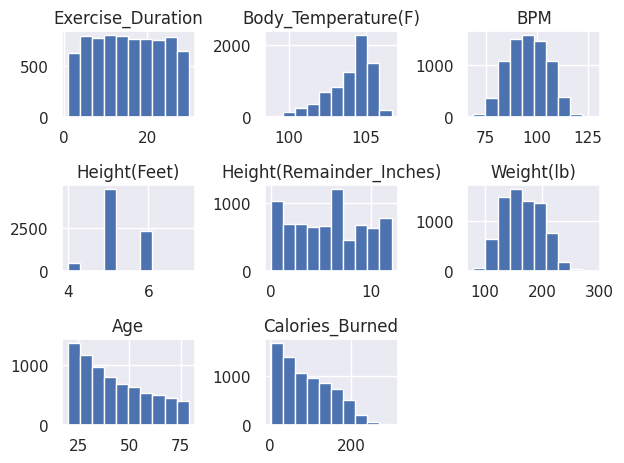

In [ ]:
train.hist()
plt.tight_layout()
plt.show()

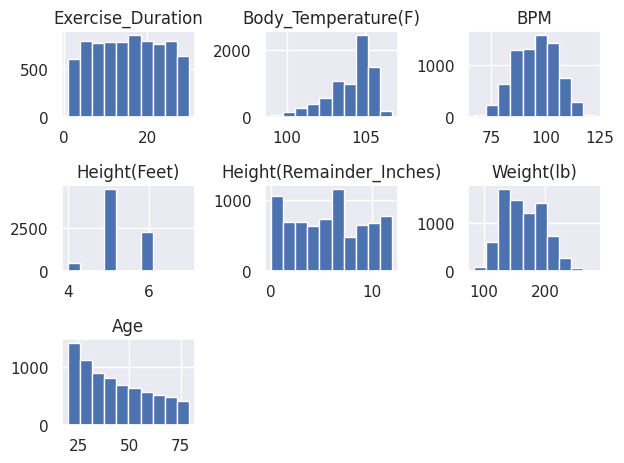

In [ ]:
test.hist()
plt.tight_layout()
plt.show()

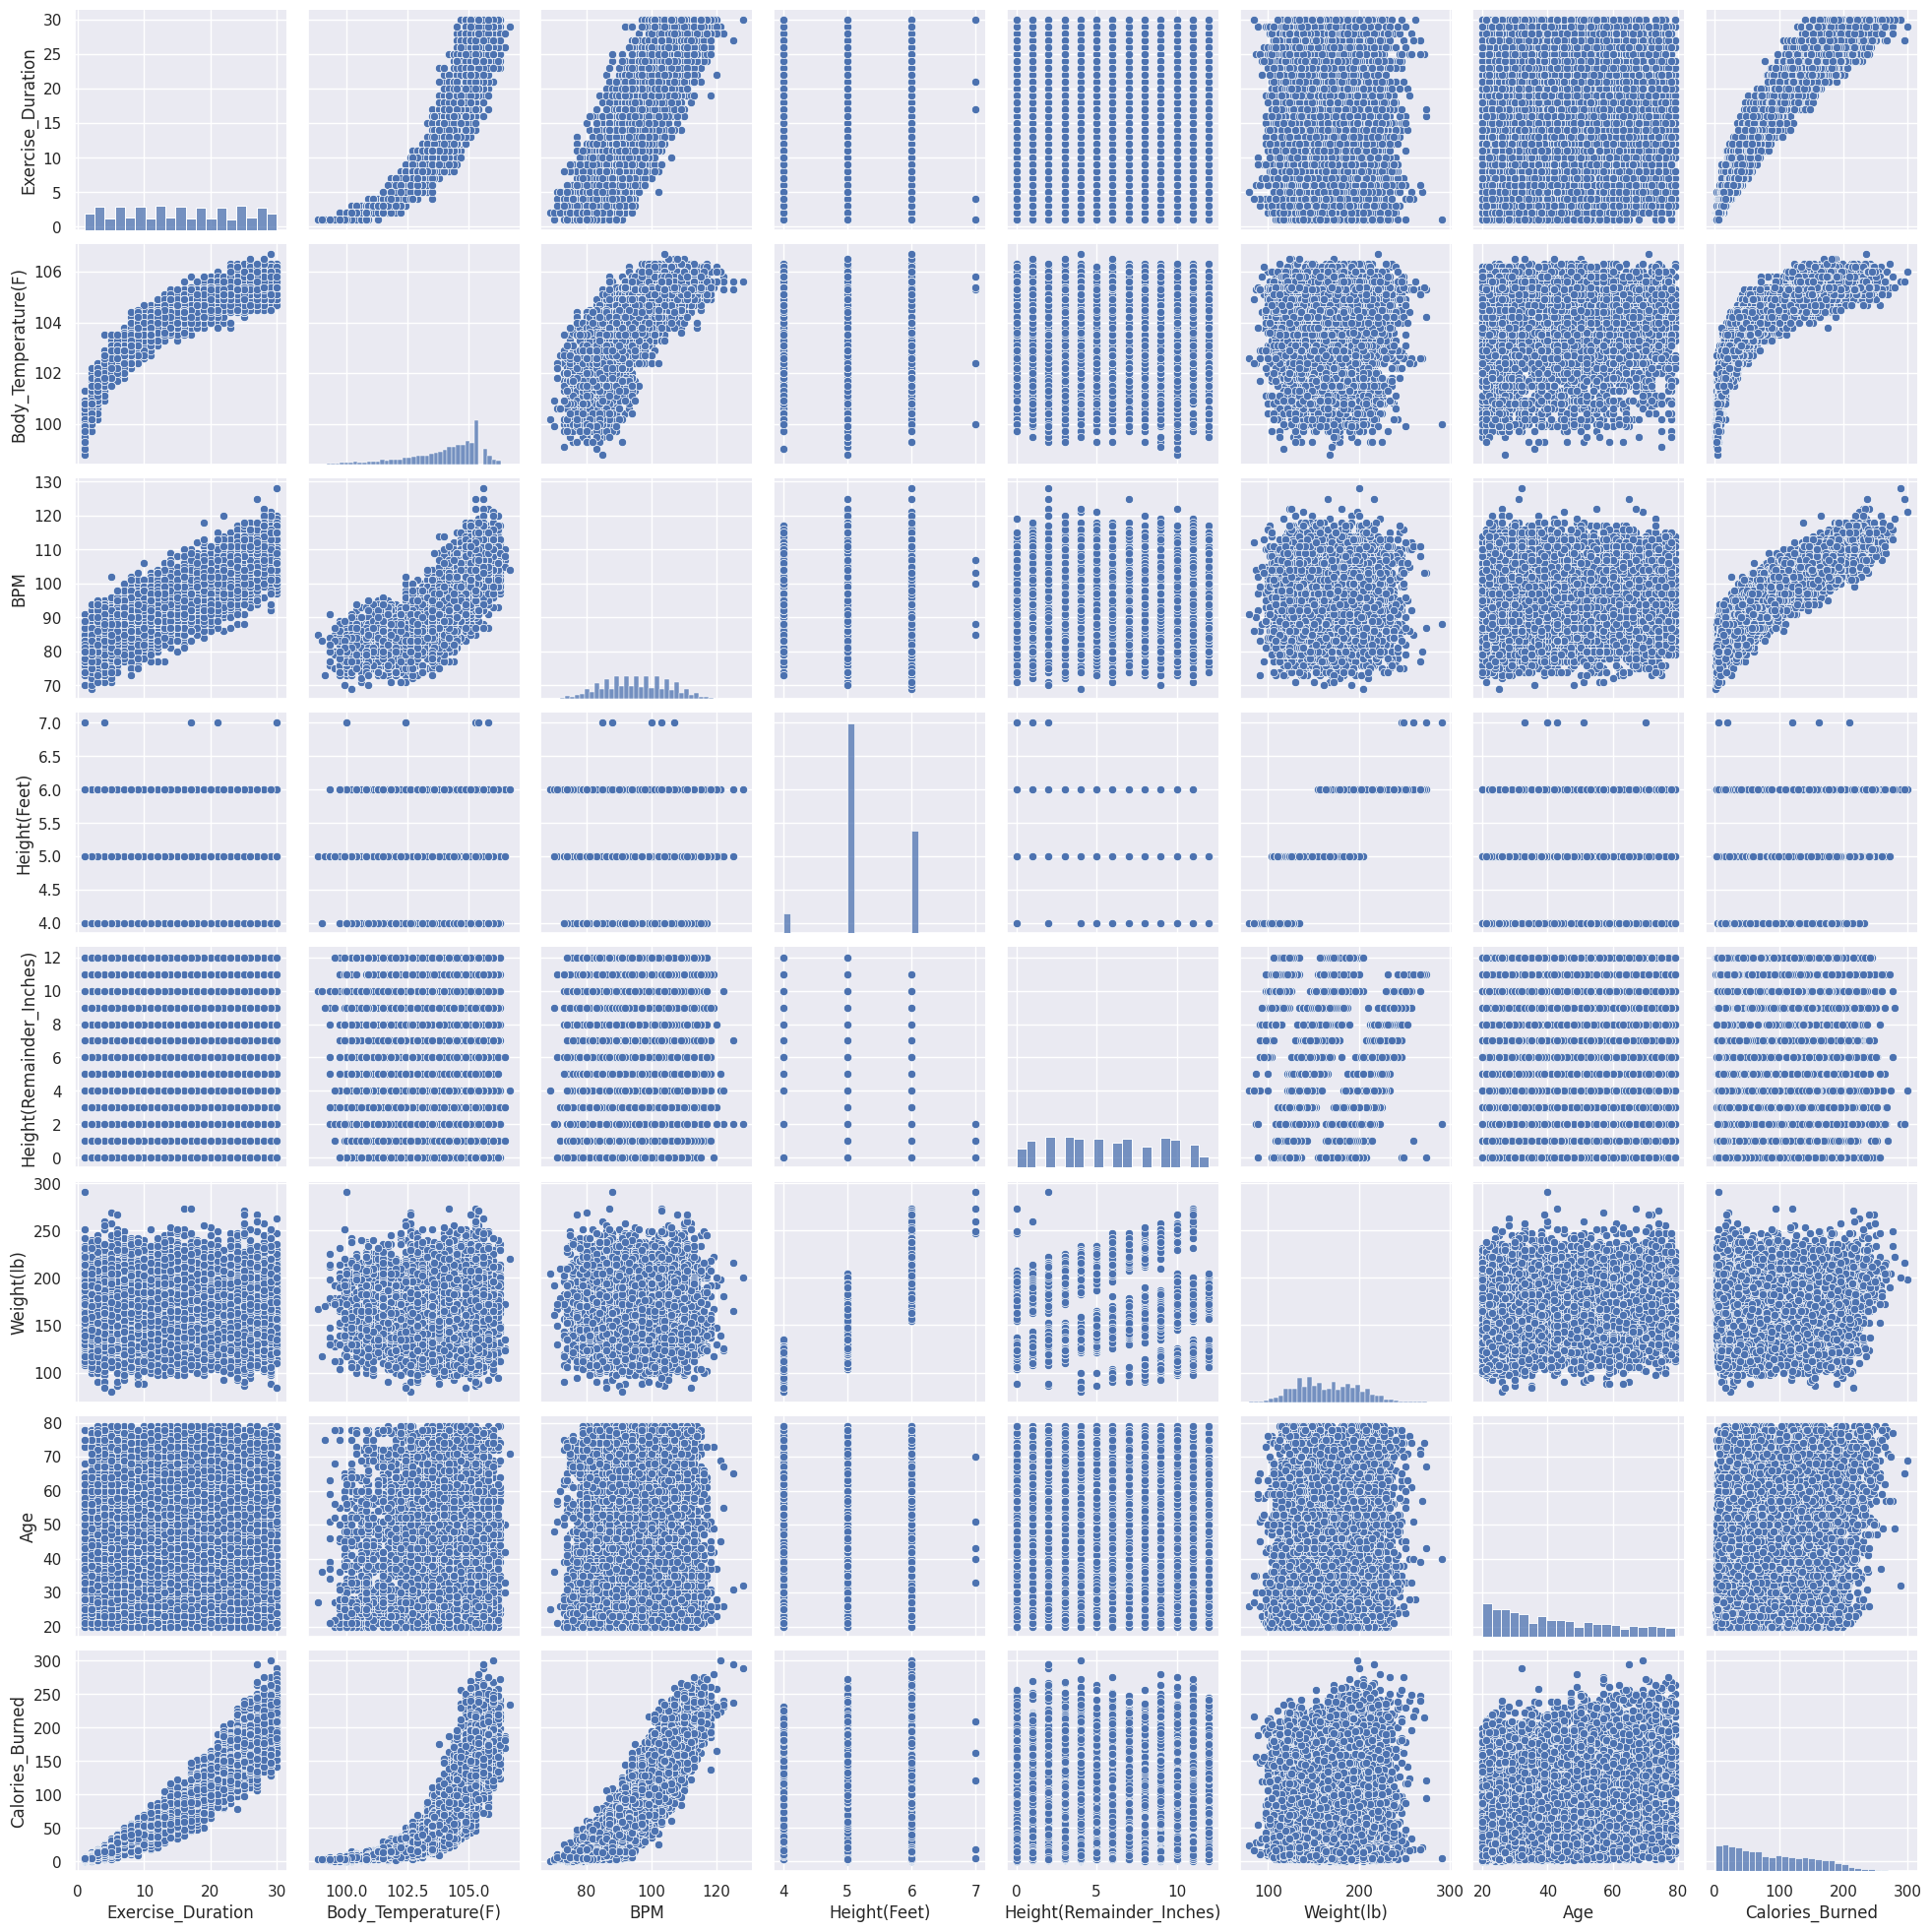

In [ ]:
sns.pairplot(train)
plt.show()

## Height

In [22]:
train['Height(Inches)'] = train['Height(Feet)']*12
train['Height(Inches)'] = train['Height(Inches)'] + train['Height(Remainder_Inches)']

test['Height(Inches)'] = test['Height(Feet)']*12
test['Height(Inches)'] = test['Height(Inches)'] + test['Height(Remainder_Inches)']

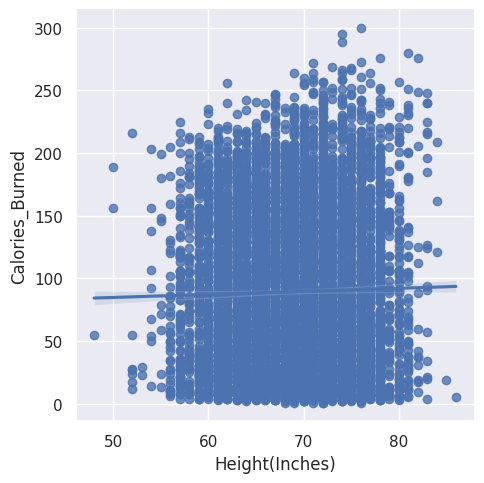

In [23]:
sns.lmplot(train, x = 'Height(Inches)', y='Calories_Burned')
plt.show()

## bmi

In [24]:
train['Height(m)'] = train['Height(Inches)']/39.37
test['Height(m)'] = test['Height(Inches)']/39.37

train['Weight(kg)'] = train['Weight(lb)']/2.205
test['Weight(kg)'] = test['Weight(lb)']/2.205

In [25]:
train['bmi'] = train['Weight(kg)']/(train['Height(m)']**2)
test['bmi'] = test['Weight(kg)']/(test['Height(m)']**2)

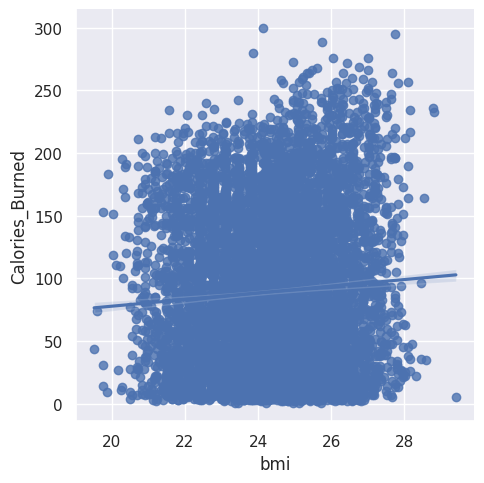

In [26]:
sns.lmplot(train, x = 'bmi', y='Calories_Burned')
plt.show()

## Weight_Status

In [27]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse=False)
oh.fit(train['Weight_Status'].values.reshape(-1,1))
temp = oh.transform(train['Weight_Status'].values.reshape(-1,1))
temp = pd.DataFrame(temp, columns=['Normal', 'Obese', 'OverWeight'])
train = pd.concat([train, temp], axis=1)

temp = oh.transform(test['Weight_Status'].values.reshape(-1,1))
temp = pd.DataFrame(temp, columns=['Normal', 'Obese', 'OverWeight'])
test = pd.concat([test, temp], axis=1)

## Gender

In [28]:
train['Gender'] = train['Gender'].replace(['F','M'], [0, 1])
test['Gender'] = test['Gender'].replace(['F','M'], [0, 1])

## 파생변수 (기초대사량)

In [29]:
min_ex = min(train['Exercise_Duration'])
max_ex = max(train['Exercise_Duration'])
ex_range = max_ex- min_ex
# min_ex, max_ex, ex_range
train['Exercise_gubun'] = pd.cut(train['Exercise_Duration'], [0, min_ex+(0.2*ex_range), min_ex+(0.4*ex_range), min_ex+(0.6*ex_range), min_ex+(0.8*ex_range), max_ex+10])
train['Exercise_gubun'] = train['Exercise_gubun'].astype('category').cat.codes

test['Exercise_gubun'] = pd.cut(test['Exercise_Duration'], [0, min_ex+(0.2*ex_range), min_ex+(0.4*ex_range), min_ex+(0.6*ex_range), min_ex+(0.8*ex_range), max_ex+10])
test['Exercise_gubun'] = test['Exercise_gubun'].astype('category').cat.codes

train['Exercise_gubun'].value_counts()

1    1572
2    1557
3    1518
4    1435
0    1418
Name: Exercise_gubun, dtype: int64

In [30]:
# 기초대사량 계산 Harris Benedict (해리스 베네딕트 방정식)
# 남자: 66.5 + (13.75 X 체중 kg) + (5.003 X 키 cm) - (6.75 X 나이)
# 여자: 655.1 + (9.563 X 체중 kg) + (1.850 X 키 cm) - (4.676 X 나이)

train['harris'] = np.where(train['Gender']==0, 655.1 + (9.563*train['Weight(kg)']) + (185 * train['Height(m)'])-(4.676*train['Age'])
                           , 66.5 + (13.75*train['Weight(kg)']) + (500.3 * train['Height(m)'])-(6.75*train['Age']))
test['harris'] = np.where(test['Gender']==0, 655.1 + (9.563*test['Weight(kg)']) + (185 * test['Height(m)'])-(4.676*test['Age'])
                           , 66.5 + (13.75*test['Weight(kg)']) + (500.3 * test['Height(m)'])-(6.75*test['Age']))

In [31]:
# 좌식(운동을 거의 또는 전혀 하지 않음): calories = BMR × 1.2;
# 가벼운 활동(가벼운 운동/스포츠 1-3일/주): calories = BMR × 1.375;
# 적당히 활동적(중간 정도의 운동/스포츠 3-5일/주): calories = BMR × 1.55;
# 매우 활동적(일주일에 6-7일 격렬한 운동/스포츠): calories = BMR × 1.725; 그리고
# 매우 활동적인 경우(매우 힘든 운동/스포츠 및 육체노동): calories = BMR × 1.9.

exidx = train[train['Exercise_gubun']==0].index
train.loc[exidx, 'harris'] = train.loc[exidx, 'harris']*1.2
exidx = train[train['Exercise_gubun']==1].index
train.loc[exidx, 'harris'] = train.loc[exidx, 'harris']*1.375
exidx = train[train['Exercise_gubun']==2].index
train.loc[exidx, 'harris'] = train.loc[exidx, 'harris']*1.55
exidx = train[train['Exercise_gubun']==3].index
train.loc[exidx, 'harris'] = train.loc[exidx, 'harris']*1.725
exidx = train[train['Exercise_gubun']==4].index
train.loc[exidx, 'harris'] = train.loc[exidx, 'harris']*1.9

exidx = test[test['Exercise_gubun']==0].index
test.loc[exidx, 'harris'] = test.loc[exidx, 'harris']*1.2
exidx = test[test['Exercise_gubun']==1].index
test.loc[exidx, 'harris'] = test.loc[exidx, 'harris']*1.375
exidx = test[test['Exercise_gubun']==2].index
test.loc[exidx, 'harris'] = test.loc[exidx, 'harris']*1.55
exidx = test[test['Exercise_gubun']==3].index
test.loc[exidx, 'harris'] = test.loc[exidx, 'harris']*1.725
exidx = test[test['Exercise_gubun']==4].index
test.loc[exidx, 'harris'] = test.loc[exidx, 'harris']*1.9

                   harris  Calories_Burned
harris           1.000000         0.579066
Calories_Burned  0.579066         1.000000


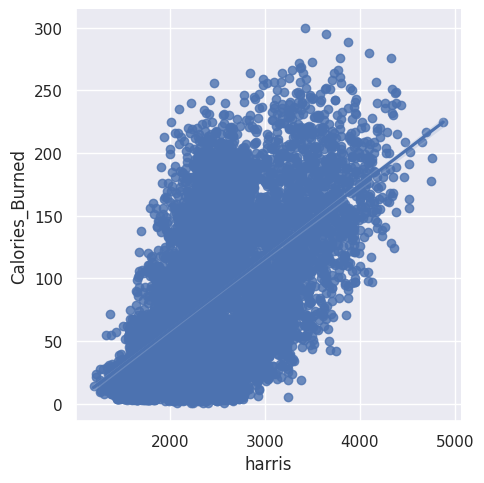

In [32]:
print(train[['harris','Calories_Burned']].corr())
sns.lmplot(train, x = 'harris', y='Calories_Burned')
plt.show()

## 상관관계

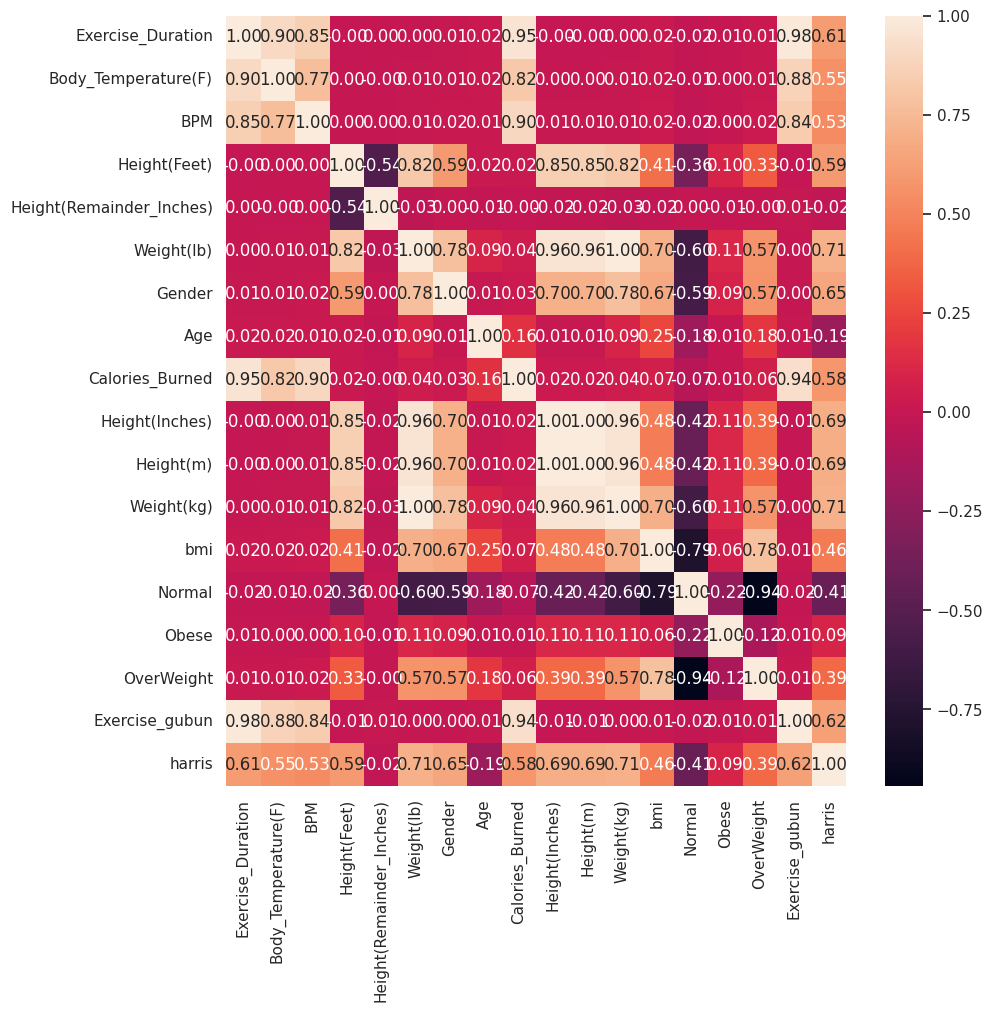

In [33]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), fmt='.2f',annot=True)
plt.show()

In [34]:
train.columns

Index(['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Height(Feet)',
       'Height(Remainder_Inches)', 'Weight(lb)', 'Weight_Status', 'Gender',
       'Age', 'Calories_Burned', 'Height(Inches)', 'Height(m)', 'Weight(kg)',
       'bmi', 'Normal', 'Obese', 'OverWeight', 'Exercise_gubun', 'harris'],
      dtype='object')

# 학습 및 검증

In [35]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# from catboost import CatBoostRegressor
# import catboost as cb
# from xgboost import XGBRegressor

In [ ]:
# col_list = ['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Weight(lb)', 'Gender', 'Age',  'Height(Inches)',
#        'bmi', 'Normal', 'Obese', 'OverWeight']  

# ss = StandardScaler()

# trainX = train[col_list]
# ss.fit(trainX)
# trainX = ss.transform(trainX)

# trainy = train['Calories_Burned']
# trainy = np.log1p(trainy)

# testX = test[col_list]
# testX = ss.transform(testX)

# model = CatBoostRegressor(random_seed=11, loss_function='RMSE')

# kf = KFold(n_splits=5, shuffle=True, random_state=11)
# score_list = cross_val_score(model, trainX, trainy, scoring='neg_root_mean_squared_error', cv=kf)
# print(f'scroe {-np.mean(score_list)}')

# model.fit(trainX, trainy,  verbose=False)
# pred = model.predict(testX)

# pred = np.expm1(pred)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['Calories_Burned'] = pred
# result.to_csv('./submit_v3.csv', index=False)

# AutoML

In [36]:
!pip install mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.9 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147060 sha256=8ec223530a8c2abafd3cd896d7c1b694967862321fba5ac1b9c960ffdf54b09e
  Stored in directory: /root/.cache/pip/whee

In [37]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(111) # Seed 고정

In [38]:
import os

from supervised.automl import AutoML

col_list = ['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Weight(kg)', 'Gender', 'Age',  'Height(m)', 'bmi', 'harris']  


trainy = train['Calories_Burned']
trainy = np.log1p(trainy)

ss = StandardScaler()

trainX = train[col_list]
ss.fit(trainX)
trainX = ss.transform(trainX)

testX = test[col_list]
testX = ss.transform(testX)

automl = AutoML(mode="Compete", eval_metric='rmse')

automl.fit(trainX, trainy)

y_pred = automl.predict(testX)

y_pred = np.expm1(y_pred)

result = pd.read_csv('/content/drive/MyDrive/핀테크_강의/Competition/CAL_CONSUM/datasets/sample_submission.csv')
result['Calories_Burned'] = y_pred
result.to_csv('/content/drive/MyDrive/핀테크_강의/Competition/CAL_CONSUM/datasets/submit_v2.csv', index=False)

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 0.228774 trained in 1.04 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree rmse 0.239187 trained in 3.91 seconds
2_DecisionTree rmse 0.198141 trained in 3.28 seconds
3_DecisionTree rmse 0.198141 trained in 4.42 seconds
4_Linear 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
